In [ ]:
# untuk menginstall library loss plot 
!pip install livelossplot

In [ ]:
# import library yang dibutuhkan

import pandas as pd
from nltk.corpus import stopwords
import seaborn as sns
from nltk.stem.porter import PorterStemmer
import re
import nltk
nltk.download('stopwords')
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# inisialisasi dataset

df = pd.read_csv('Tweets.csv')

df

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)


In [ ]:
# men-drop kolom yang tidak digunakan

df = df.drop(columns=['tweet_id',
                      'airline_sentiment_confidence',
                      'negativereason',
                      'negativereason_confidence',
                      'airline_sentiment_gold',
                      'negativereason_gold',
                      'retweet_count',
                      'tweet_coord',
                      'tweet_created',
                      'tweet_location',
                      'user_timezone',
                      'name',
                      'airline'])
df

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
...,...,...
14635,positive,@AmericanAir thank you we got on a different f...
14636,negative,@AmericanAir leaving over 20 minutes Late Flig...
14637,neutral,@AmericanAir Please bring American Airlines to...
14638,negative,"@AmericanAir you have my money, you change my ..."


In [ ]:
# menghitung tiap kelas
count_neg, count_neu, count_pos = df.airline_sentiment.value_counts()

#  kelas menjadi dataframe baru
df_class_neg = df[df['airline_sentiment'] == 'negative']
df_class_neu = df[df['airline_sentiment'] == 'neutral']
df_class_pos = df[df['airline_sentiment'] == 'positive']



Random over-sampling:
positive    9178
negative    9178
neutral     9178
Name: airline_sentiment, dtype: int64


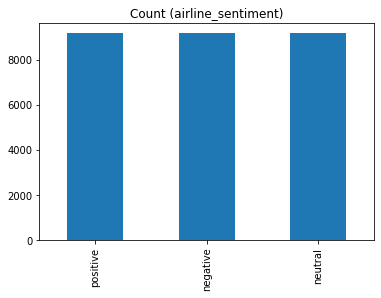

In [ ]:
# dikarenakan sample tidak seimbang, maka dilakukan pemerataan dengan resample

df_class_pos_over = df_class_pos.sample(count_neg, replace=True)
df_class_neu_over = df_class_neu.sample(count_neg, replace=True)
df_test_over = pd.concat([df_class_neg, df_class_pos_over, df_class_neu_over], axis=0)

print('Random over-sampling:')
print(df_test_over.airline_sentiment.value_counts())

df_test_over.airline_sentiment.value_counts().plot(kind='bar', title='Count (airline_sentiment)');

In [ ]:
# one hot encode 

category = pd.get_dummies(df_test_over.airline_sentiment)
df_fix = pd.concat([df_test_over, category], axis=1)
df_fix = df_fix.drop(columns='airline_sentiment')
df_fix

,text,negative,neutral,positive
3,@VirginAmerica it's really aggressive to blast...,1,0,0
4,@VirginAmerica and it's a really big bad thing...,1,0,0
5,@VirginAmerica seriously would pay $30 a fligh...,1,0,0
15,@VirginAmerica SFO-PDX schedule is still MIA.,1,0,0
17,@VirginAmerica I flew from NYC to SFO last we...,1,0,0
...,...,...,...,...
1862,@united getting ready to book a flight to San ...,0,1,0
12419,"@AmericanAir travel week, delays, Cancelled Fl...",0,1,0
14546,@AmericanAir how realistic is it to make an 80...,0,1,0
9308,@USAirways can you priv chat to help chairman ...,0,1,0


In [ ]:

# fungsi untuk membersihkan text
def clean_text(text):
    # menghapus backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # menghapus semua karakter kecuali alfabet 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # menghapus whitespaces 
    text = ' '.join(text.split()) 
    
    return text

In [ ]:
# mengaplikasikan pada dataset
df_fix['text'] = df_fix['text'].apply(lambda x: clean_text(x))

df_fix


,text,negative,neutral,positive
3,VirginAmerica its really aggressive to blast o...,1,0,0
4,VirginAmerica and its a really big bad thing a...,1,0,0
5,VirginAmerica seriously would pay a flight for...,1,0,0
15,VirginAmerica SFO PDX schedule is still MIA,1,0,0
17,VirginAmerica I flew from NYC to SFO last week...,1,0,0
...,...,...,...,...
1862,united getting ready to book a flight to San J...,0,1,0
12419,AmericanAir travel week delays Cancelled Fligh...,0,1,0
14546,AmericanAir how realistic is it to make an min...,0,1,0
9308,USAirways can you priv chat to help chairman r...,0,1,0


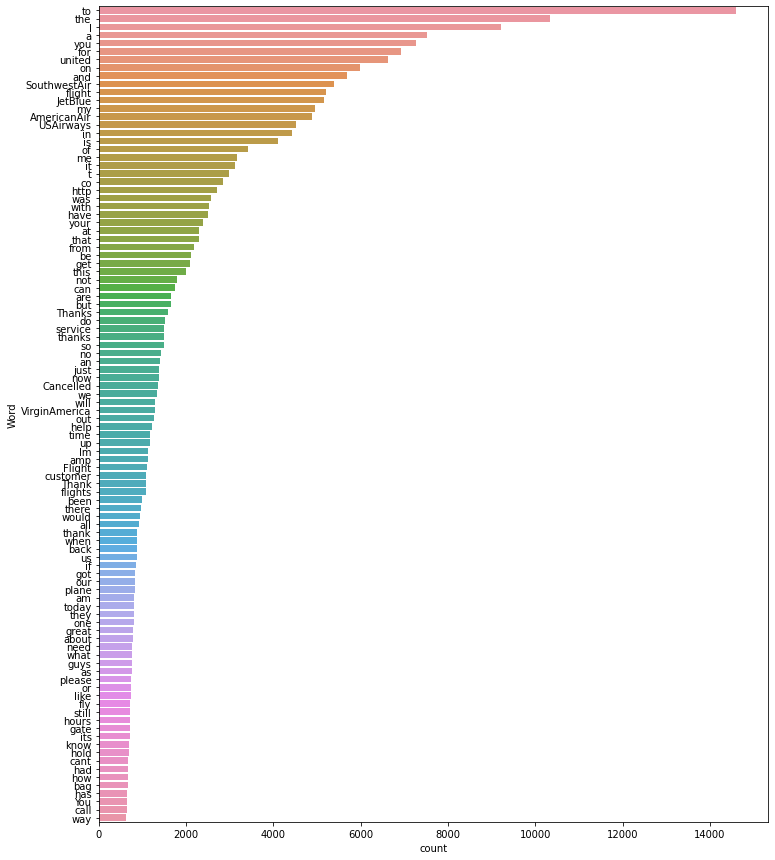

In [ ]:
# fungsi untuk menghitung jumlah kata terbanyak di dalam dataset

def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  #  top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  
# print 100 most frequent words 
freq_words(df_fix['text'], 100)

In [ ]:
# menghapus stopword pada dataset

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

df_fix['text'] = df_fix['text'].apply(lambda x: remove_stopwords(x))


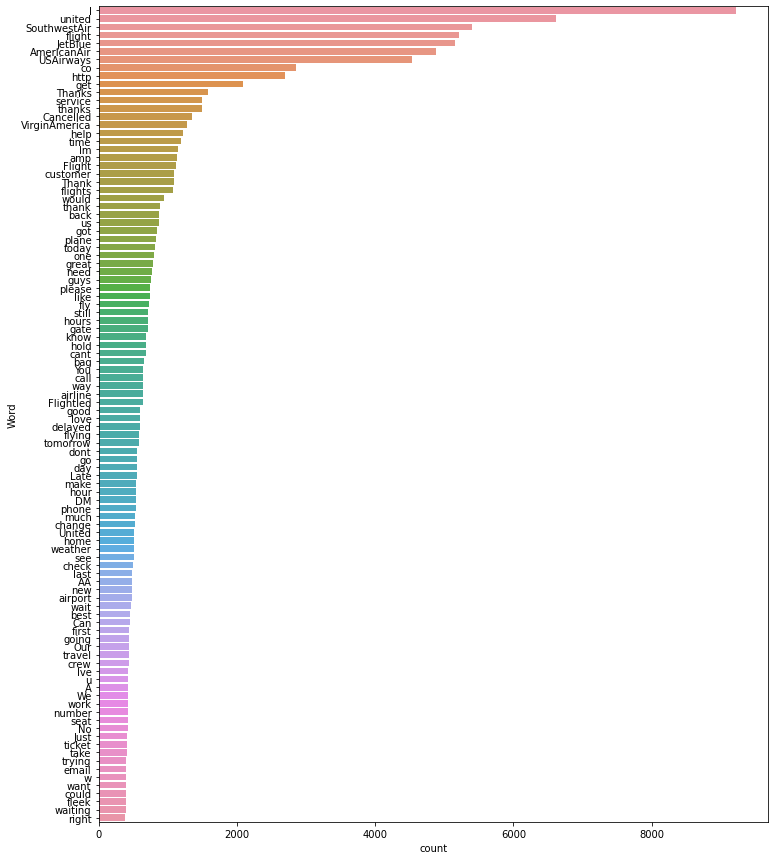

In [ ]:
freq_words(df_fix['text'], 100)

In [ ]:
# inisiasi variabel

text = df_fix['text'].values
label_sentiment = df_fix[['negative', 
                      'neutral',
                      'positive']].values

In [ ]:
# split data train dan data test

from sklearn.model_selection import train_test_split
plot_train, plot_test, label_genre_train, label_genre_test = train_test_split(text, label_sentiment, test_size=0.2)

In [ ]:
# Tokenisasi

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=4000, oov_token='x')
tokenizer.fit_on_texts(plot_train) 
tokenizer.fit_on_texts(plot_test)
 
sequences_train = tokenizer.texts_to_sequences(plot_train)
sequences_test = tokenizer.texts_to_sequences(plot_test)
 
padded_train = pad_sequences(sequences_train) 
padded_test = pad_sequences(sequences_test)

In [ ]:
# buat model 

import keras
from keras.regularizers import l1,l2
from tensorflow.keras import regularizers
import tensorflow as tf
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=4000, output_dim=128),
    tf.keras.layers.LSTM(256),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         512000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               394240    
_________________________________________________________________
dense_6 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                

In [ ]:
# membuat callback

import livelossplot

# inisiasi plot loss
plot_losses = livelossplot.PlotLossesKeras()

# ketika val_acc > 91%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.91):
      print("\nAkurasi telah mencapai >90%!")
      self.model.stop_training = True
callbacks_end = myCallback()

# learning rate scheduler
def scheduler(epoch, lr):
  if epoch < 1:
    return lr
  else:
    return lr * tf.math.exp(-0.9)
callbacks_lr = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

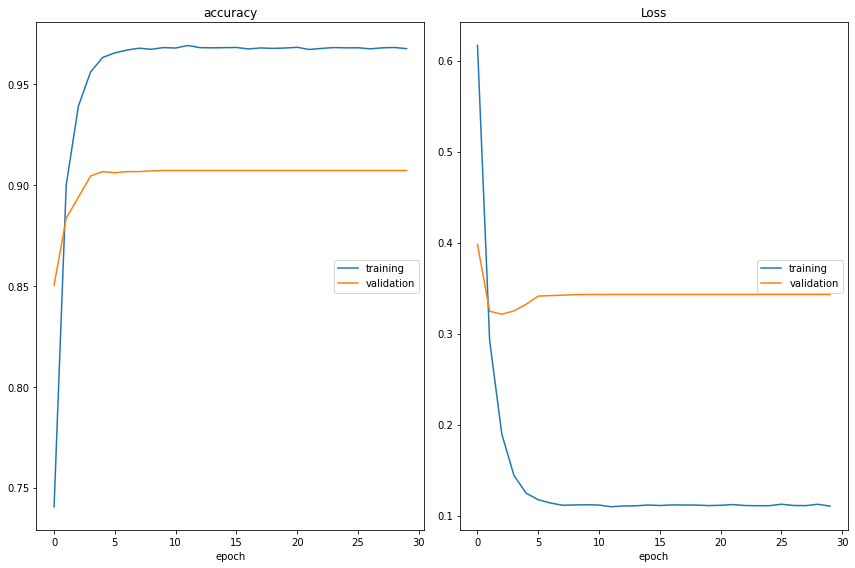

accuracy
	training         	 (min:    0.741, max:    0.969, cur:    0.968)
	validation       	 (min:    0.850, max:    0.907, cur:    0.907)
Loss
	training         	 (min:    0.110, max:    0.617, cur:    0.110)
	validation       	 (min:    0.321, max:    0.398, cur:    0.343)
689/689 [==============================] - 91s 132ms/step - loss: 0.1103 - accuracy: 0.9676 - val_loss: 0.3429 - val_accuracy: 0.9072


In [ ]:
# latih model

history = model.fit(padded_train,
                    label_genre_train,
                    epochs=30,
                    verbose=1,
                    callbacks=[plot_losses, callbacks_end, callbacks_lr],
                    validation_data=(padded_test, label_genre_test))